In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import keras

2024-09-04 16:24:57.251609: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 16:24:57.251765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 16:24:57.393198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import shutil
import random
from concurrent.futures import ThreadPoolExecutor

def create_directory_structure(base_dir, class_names):
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

def copy_file(src_dest_tuple):
    src_path, dest_path = src_dest_tuple
    shutil.copy(src_path, dest_path)

def copy_files(file_list, destination_folder):
    tasks = []
    for file_path in file_list:
        class_name = os.path.basename(os.path.dirname(file_path))
        dest_path = os.path.join(destination_folder, class_name, os.path.basename(file_path))
        tasks.append((file_path, dest_path))
    
    with ThreadPoolExecutor() as executor:
        executor.map(copy_file, tasks)

# Set paths
input_folder = '/kaggle/input/leaf-dataset-main/Leaf_dataset_main'
output_folder = 'Normalized_Dataset'
train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

# List all class folders
class_folders = [f for f in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, f))]

# Filter out classes with fewer than 80 images
valid_class_folders = []
for class_folder in class_folders:
    class_path = os.path.join(input_folder, class_folder)
    files = [f for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    if len(files) >= 80:
        valid_class_folders.append(class_folder)

# Create output directories
create_directory_structure(train_folder, valid_class_folders)
create_directory_structure(val_folder, valid_class_folders)
create_directory_structure(test_folder, valid_class_folders)

# Process each class separately
for class_folder in valid_class_folders:
    class_path = os.path.join(input_folder, class_folder)
    files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('jpg', 'jpeg', 'png'))]
    
    # Limit to at most 100 images per class
    if len(files) > 120:
        files = random.sample(files, 120)
    total_files = len(files)
    
    # Calculate split sizes
    train_size = int(total_files * 0.7)
    val_size = int(total_files * 0.2)
    test_size = total_files - train_size - val_size

    # Shuffle files to ensure random distribution
    random.shuffle(files)

    # Split into train, validation, and test
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]
    
    # Copy files to respective folders
    copy_files(train_files, train_folder)
    copy_files(val_files, val_folder)
    copy_files(test_files, test_folder)

print("Dataset copying complete!")

Dataset copying complete!


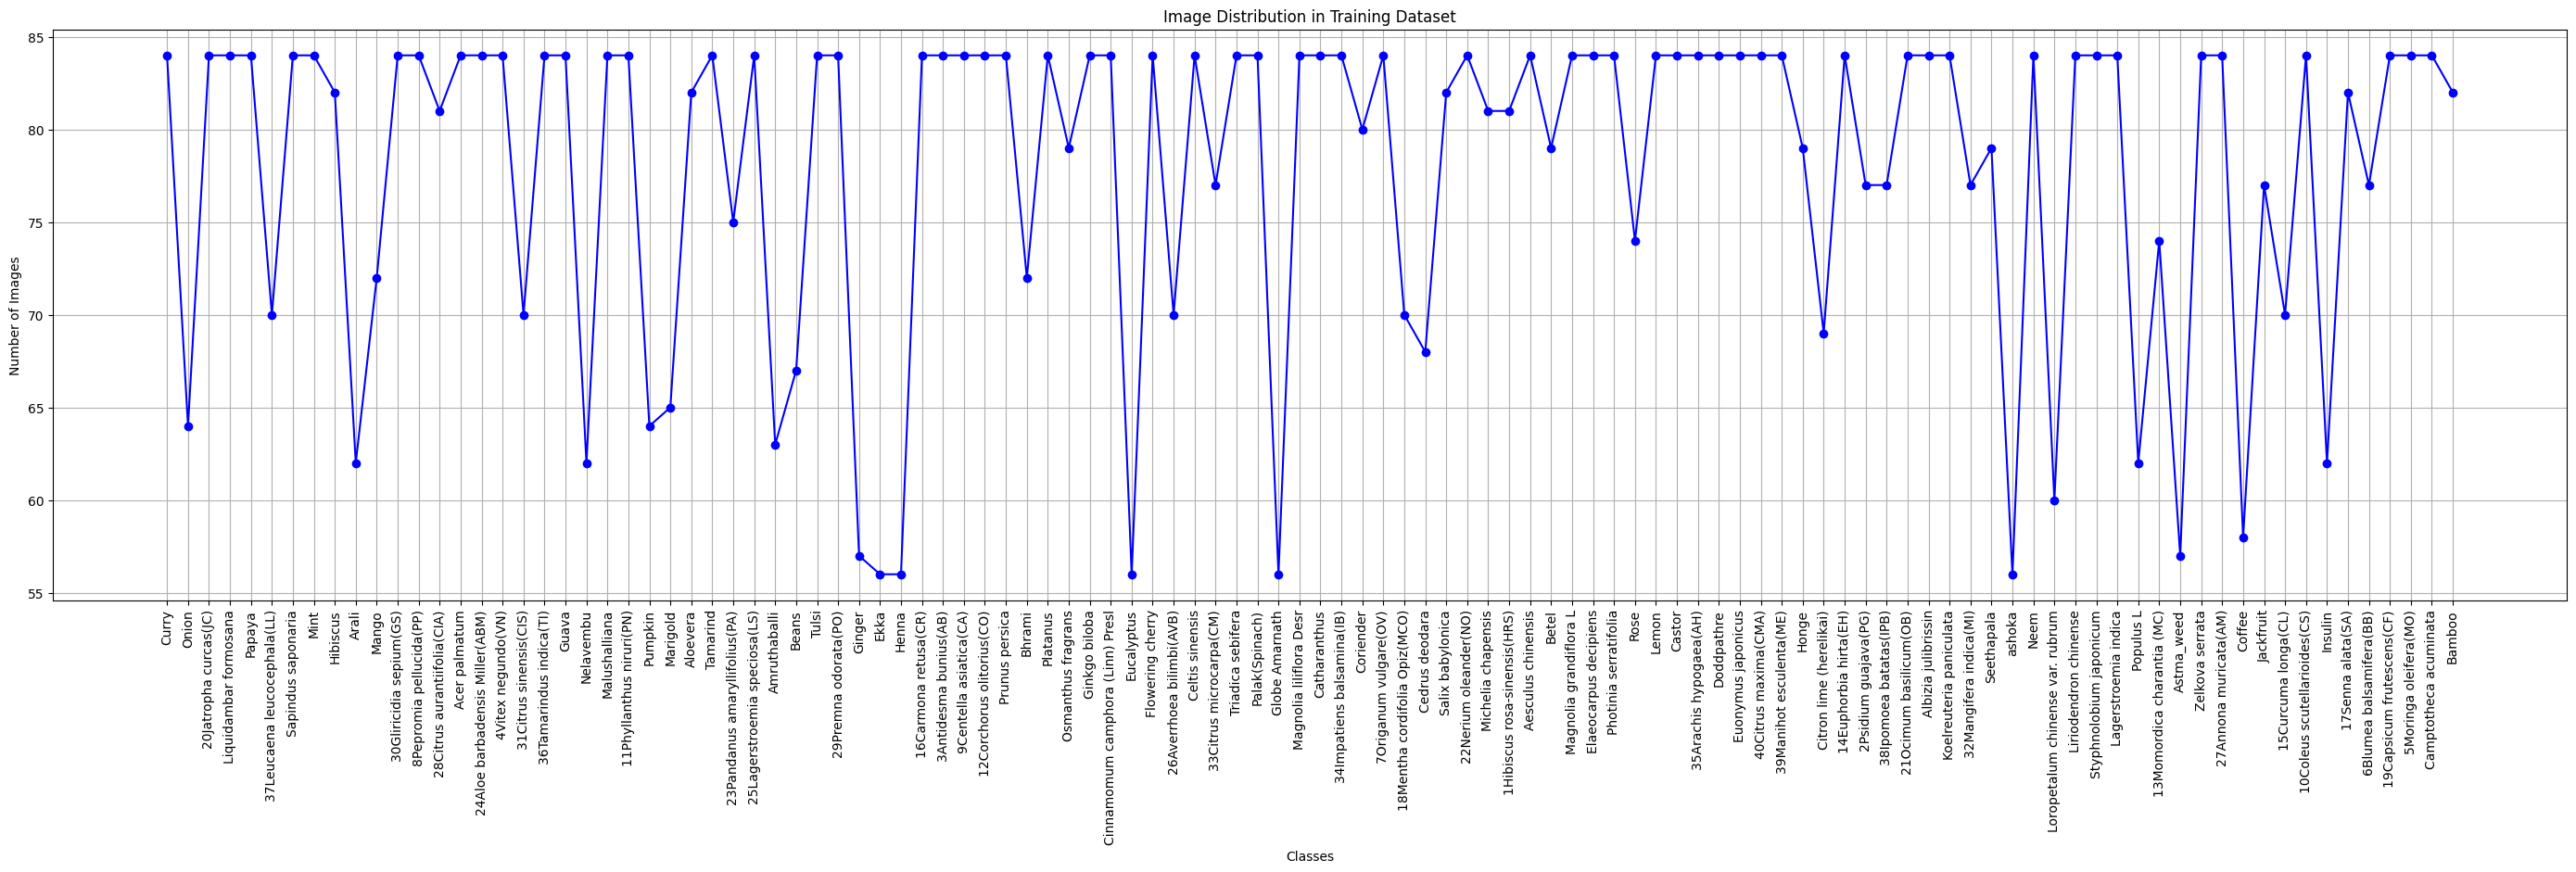

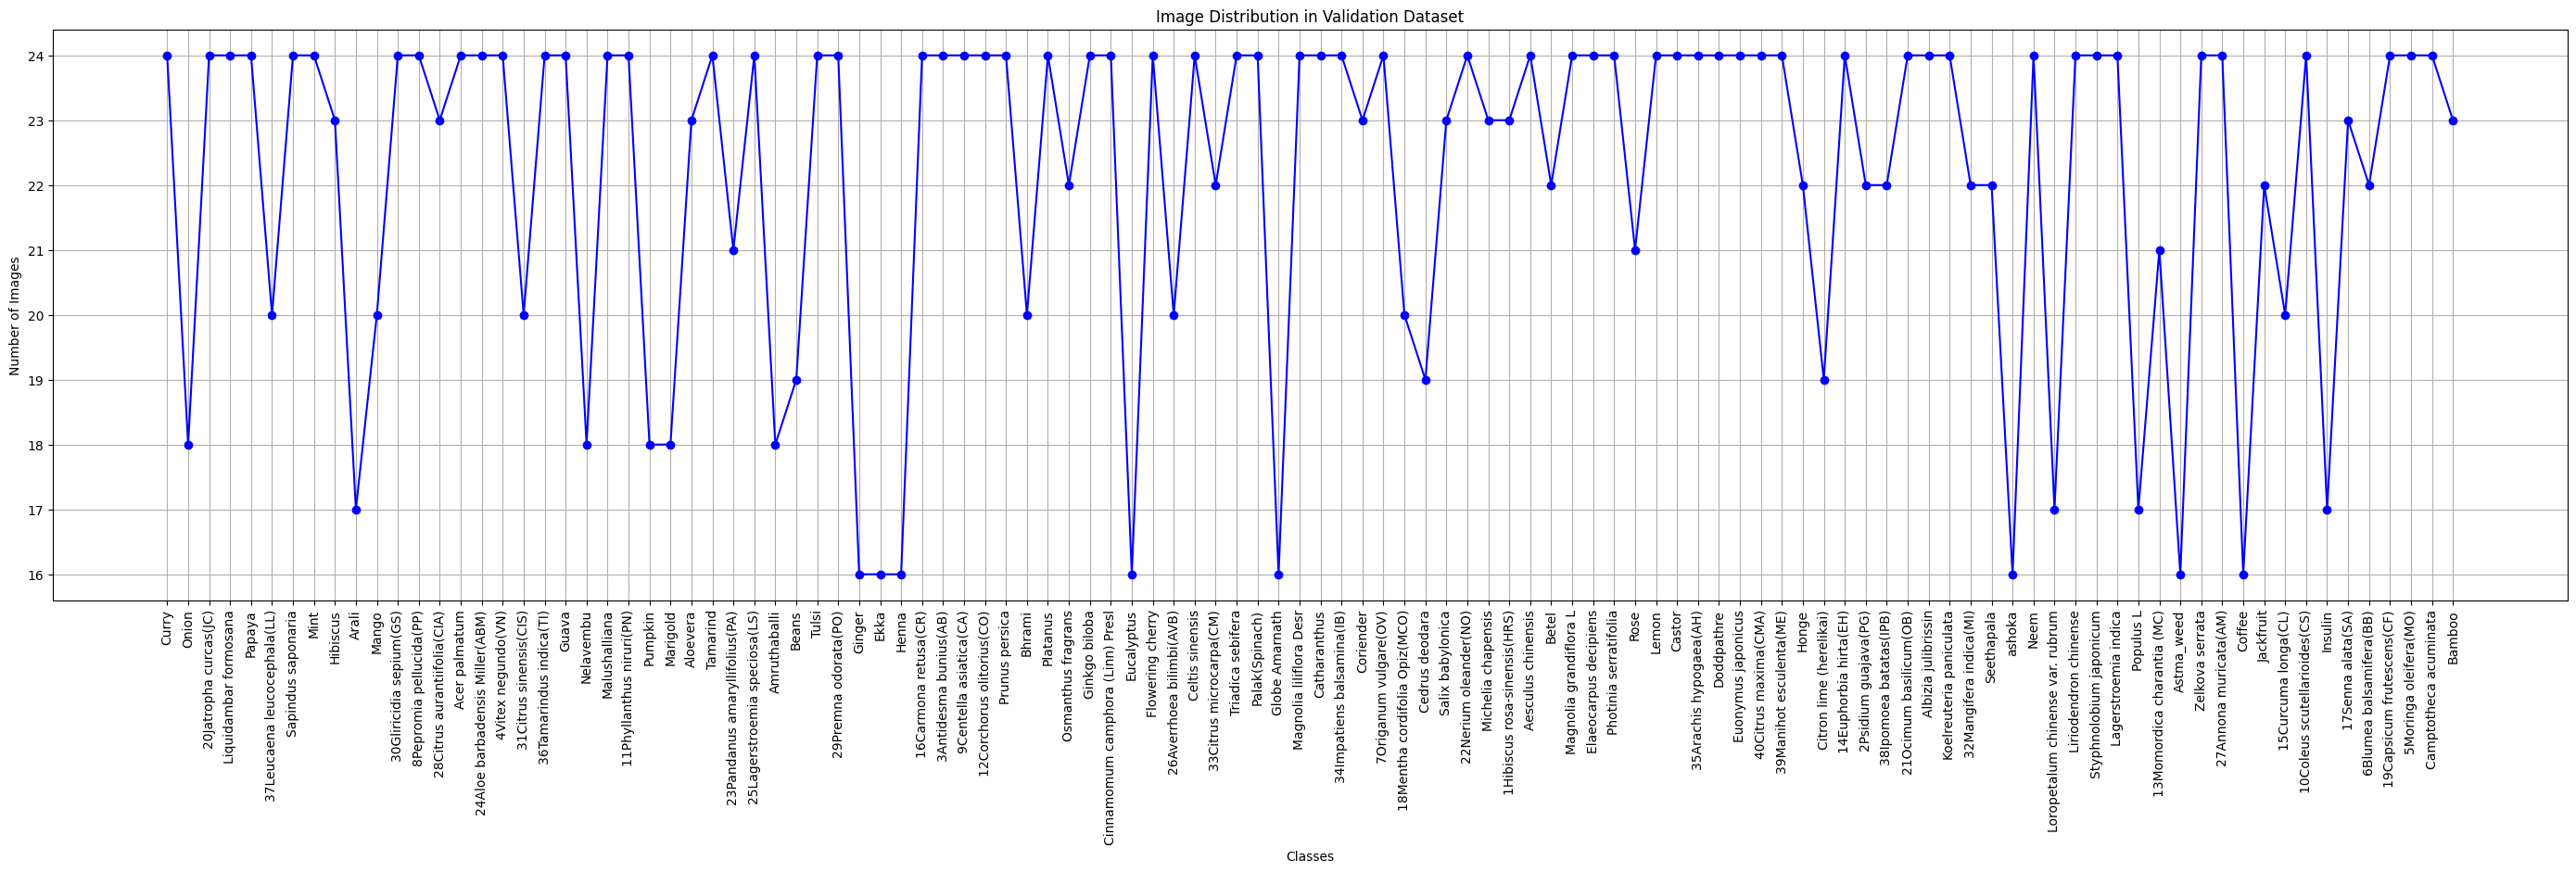

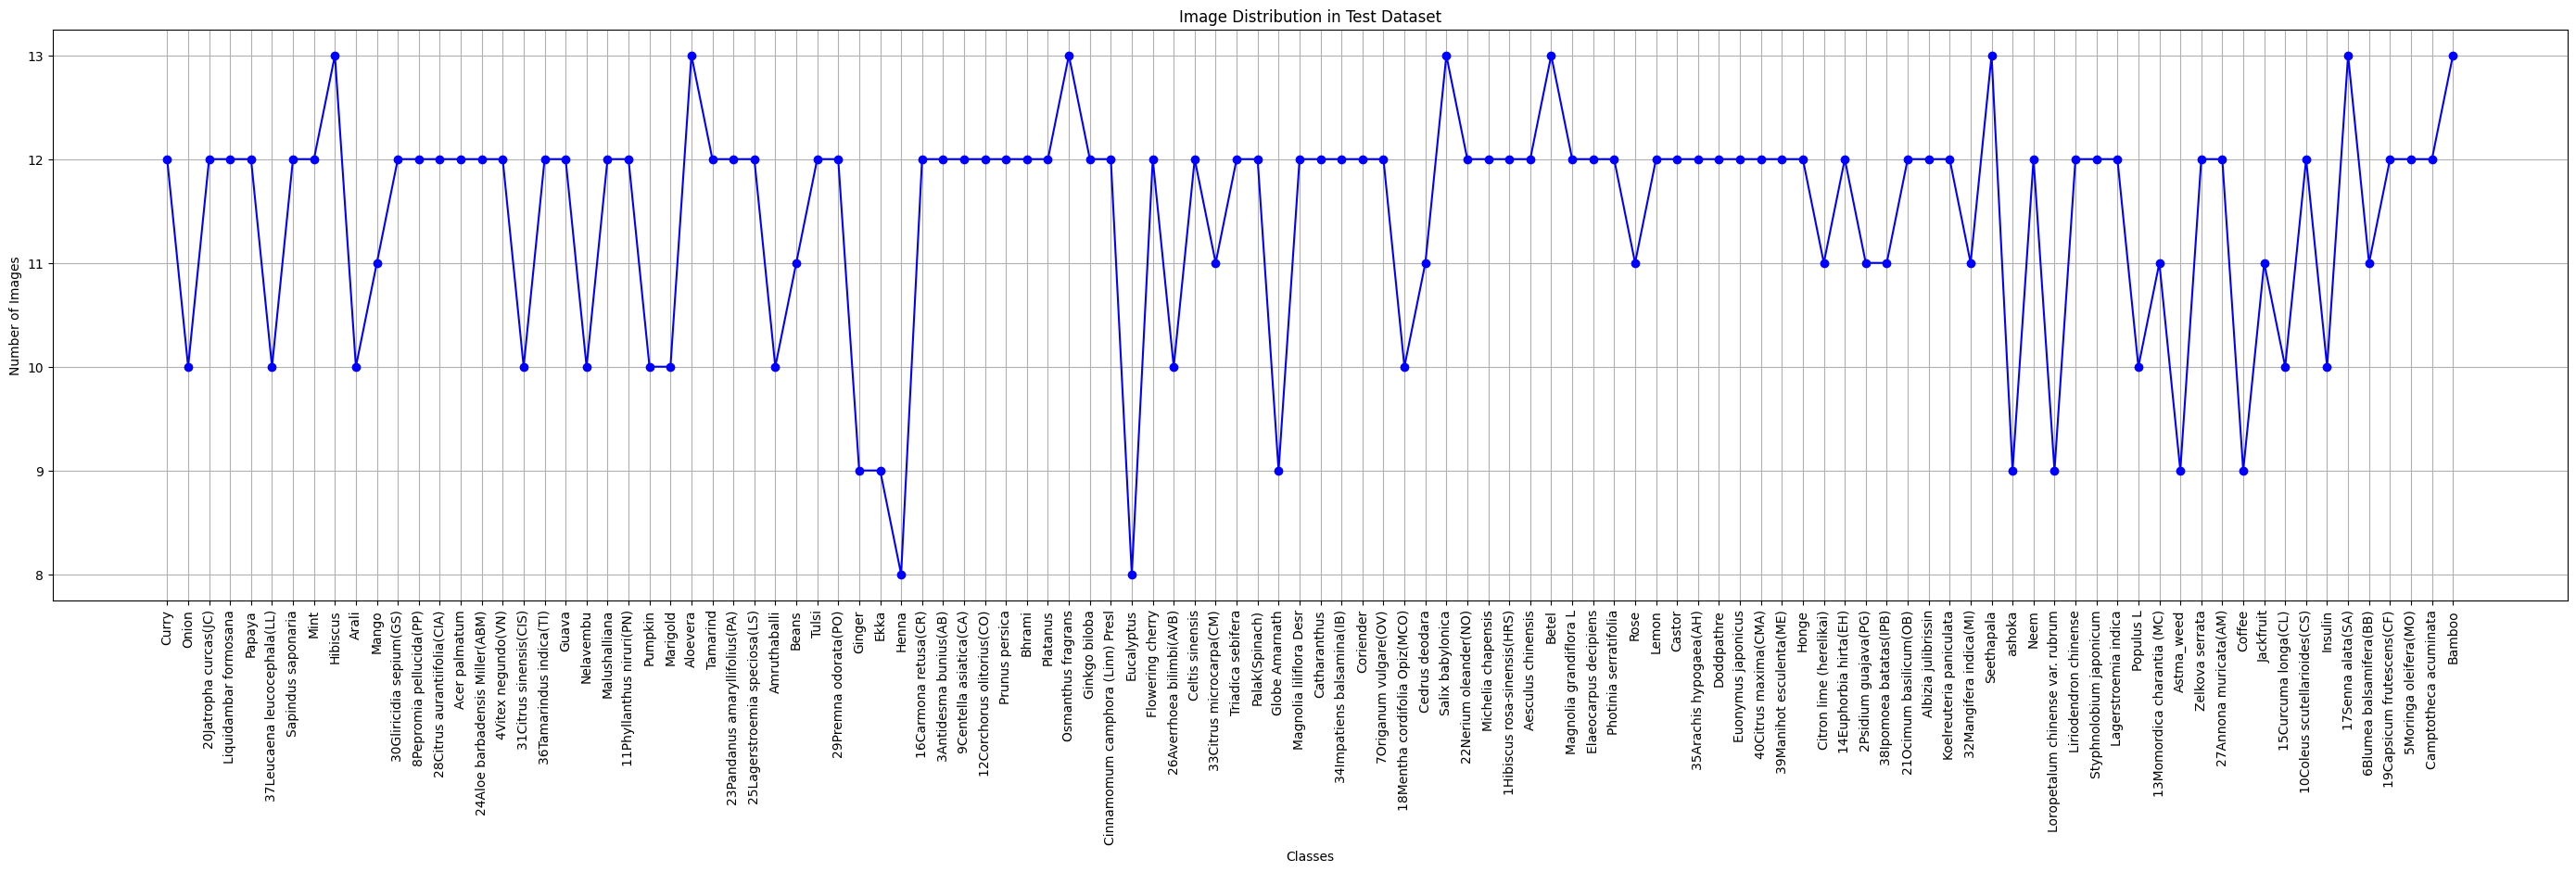

In [3]:
import os
import matplotlib.pyplot as plt

def count_images_in_classes(folder_path):
    class_image_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            image_count = len([f for f in os.listdir(class_folder) if f.endswith(('jpg', 'jpeg', 'png'))])
            class_image_counts[class_name] = image_count
    return class_image_counts

def plot_line_graph(image_counts, title):
    classes = list(image_counts.keys())
    counts = list(image_counts.values())
    
    plt.figure(figsize=(35, 8))
    plt.plot(classes, counts, marker='o', linestyle='-', color='b')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.grid(True)
    plt.show()

# Set the paths to your train, val, and test directories
train_folder = 'Normalized_Dataset/train'
val_folder = 'Normalized_Dataset/val'
test_folder = 'Normalized_Dataset/test'

# Count images in each class for train, val, and test
train_image_counts = count_images_in_classes(train_folder)
val_image_counts = count_images_in_classes(val_folder)
test_image_counts = count_images_in_classes(test_folder)

# Plot the class distribution as line graphs for train, val, and test
plot_line_graph(train_image_counts, "Image Distribution in Training Dataset")
plot_line_graph(val_image_counts, "Image Distribution in Validation Dataset")
plot_line_graph(test_image_counts, "Image Distribution in Test Dataset")


In [5]:
# Create ImageDataGenerator with augmentation for train and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

# Create train generator
train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse'
)

# Create validation generator (no need for subset='validation')
val_generator = datagen.flow_from_directory(
    val_folder,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse'
)

# Create test generator (no augmentation, no validation split)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=128,
    class_mode='sparse',
    shuffle=False  # Do not shuffle test data
)

Found 8572 images belonging to 110 classes.
Found 2437 images belonging to 110 classes.
Found 1261 images belonging to 110 classes.


In [ ]:
base_model = ResNet152V2(include_top=False,
                  input_shape=(224,224,3),
                   weights = 'imagenet',
                    pooling='avg'
                  )
base_model.trainable = False

inputs = base_model.input
l1 = Dense(512,activation='relu')(base_model.output)
outputs = Dense(110,activation='softmax')(l1)
model = keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='best_model_classification.keras',  # File path where the model will be saved
    monitor='val_accuracy',    # Metric to monitor
    verbose=1,                 # Verbosity mode, 1 will log messages when saving the model
    save_best_only=True,       # Only save the model if `val_accuracy` improves
    mode='max'                 # We want to maximize validation accuracy
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stopping, reduce_lr, checkpoint], 
)

In [ ]:
model.save('leaf_detection_model.h5')

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('leaf_detection_model.h5')